In [1]:
#!/usr/bin/env python
# coding: utf-8

from datetime import date, datetime, timedelta
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import requests
import seaborn as sns
import statistics
from scipy.ndimage.filters import gaussian_filter1d

import chart_simple as chs

import time
start = time.time()

In [2]:
theme = 'mono'

In [3]:
plt.rcParams['figure.max_open_warning'] = 0
plt.rcParams['figure.autolayout'] = True

today = date.today().strftime('%Y-%m-%d')

In [4]:
def get_weekday():
    weekDays = ('Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday')
    current_year = date.today().strftime('%Y')
    month = datetime.today().strftime('%B')
    today_ = datetime.today()
    day = datetime.today().strftime('%d')

    weekday_num = today_.weekday()
    weekday = weekDays[weekday_num]
    return month, day, weekday

def utc_convert(string):
    day = int(string[8:10])
    month = int(string[5:7])
    year = int(string[:4])
    offset = 693594
    itime = datetime(year,month,day)
    n = itime.toordinal()
    m = (n - offset)
    return m

def utc_to_date(utc):
    offset = 693594
    ordinal = offset + int(utc)
    new_date = date.fromordinal(ordinal)
    return new_date

def utc_convert_batch(string):
    today_ = date.today().strftime('%Y-%m-%d')
    try:
        day = int(string[8:10])
        month = int(string[5:7])
        year = int(string[:4])
        offset = 693594
        itime = datetime(year,month,day)
        n = itime.toordinal()
        m = (n - offset)
        return m
    except:
        return utc_today

def utc_count(dataframe):
    count_16 = dataframe['utc'].values
    unique_dates = dataframe['utc'].unique()
    a = [[date_,int((count_16 == date_).sum())] for date_ in unique_dates]
    db = pd.DataFrame(a,columns=['date','count'])
    db = db.sort_values(by=['date'])
    db['date'] = db['date'].apply(lambda x: utc_to_date(x))
    db['days'] = db['date'].apply(lambda x: str(x)[-2:])
    db = db.dropna()
    db['days'] = db['days'].astype(int)
    db = db.sort_values(by='days')
    return db

def case_age_gender(age,gender,on_db):
    results = on_db[(on_db['Client_Gender'] == gender) & (on_db['Age_Group'] == age)]['Case_Reported_Date'].values
    unique_dates = on_db['Accurate_Episode_Date'].unique()
    a = [[date_,int((results == date_).sum())] for date_ in unique_dates]
    db = pd.DataFrame(a,columns=['date','count'])
    db = db.sort_values(by=['date'])
    db['days'] = range(db.shape[0])
    db = db.dropna()
    return db

def all_age_count(age,on_db):
    results = on_db[on_db['Age_Group'] == age]['Case_Reported_Date'].values
    unique_dates = on_db['Accurate_Episode_Date'].unique()
    a = [[date_,int((results == date_).sum())] for date_ in unique_dates]
    db = pd.DataFrame(a,columns=['date','count'])
    db = db.sort_values(by=['date'])
    db['days'] = range(db.shape[0])
    db = db.dropna()
    return db

def all_cases_count(on_db):
    results = on_db['Accurate_Episode_Date'].values
    unique_dates = on_db['Accurate_Episode_Date'].unique()
    a = [[date_,int((results == date_).sum())] for date_ in unique_dates]
    db = pd.DataFrame(a,columns=['date','count'])
    db = db.sort_values(by=['date'])
    db['days'] = range(db.shape[0])
    db = db.dropna()
    return db

def all_deaths_count(on_db):
    results = [x for x in on_db['Accurate_Episode_Date']]
    deaths = [1 if x == 'Fatal' else 0 for x in on_db['Outcome1']]
    db = pd.DataFrame()
    db['date'] = results
    db['deaths'] = deaths
    db = db.groupby('date').sum()
    db = db.sort_values(by=['date'])
    db['days'] = range(db.shape[0])
    db = db.dropna()
    return db

def f(x,y,z):
    return sum([x,y,z],1)/3

def get_category_count(dataframe,column,total_cases):
    a=[]
    for query in dataframe[column].unique():
        count = dataframe[dataframe[column] == query].count()[0]
        percentage = round(count / total_cases,2)
        a.append([query,count,percentage])
    string = column.lower()
    string = re.sub('\d+','',string)
    data = pd.DataFrame(a,columns=[string,'count','pop%'])
    data = data.sort_values(by='count',ascending=False)
    data = data.reset_index()
    data.pop('index')
    data = data[data[string] != 'UNKNOWN']
    data = data[data[string] != 'OTHER']
    data = data.dropna()
    return data

def find_explode(lst,data):
    a = [0.1 if i == data else 0 for i in lst]
    return a

def get_pie(dataframe,string,total_cases,title):
    query = string
    results = get_category_count(dataframe,query,total_cases)
    return results

In [5]:
utc_today = utc_convert(today)

print(today,utc_today)

2020-11-09 44144


In [6]:
on_db = pd.read_csv('datasets/2020/conposcovidloc.csv')
on_age = pd.read_csv('datasets/2020/age_groups_ontario.csv')

In [7]:
url = 'https://en.wikipedia.org/wiki/Demographics_of_Ontario'

In [8]:
on_db['utc'] = on_db['Case_Reported_Date'].apply(lambda x: utc_convert_batch(x))

In [9]:
total_cases = on_db['Accurate_Episode_Date'].count()
print(total_cases, 'as of today', today)

85395 as of today 2020-11-09


In [11]:
on_cases = pd.DataFrame()
j = 0
for age in on_db['Age_Group'].unique():
    for gender in on_db['Client_Gender'].unique():
        count = on_db[(on_db['Age_Group'] == age) & (on_db['Client_Gender'] == gender)].count()[0]
        percentage = round(count / total_cases,2)
        if gender == 'FEMALE':
            on_cases.at[j,'age_group'] = age
            on_cases.at[j,'female'] = count
        elif gender == 'MALE':
            on_cases.at[j,'male'] = count
        elif gender == 'GENDER DIVERSE':
            on_cases.at[j,'transgender'] = count
        else:
            on_cases.at[j,'unspecified'] = count
    j = j + 1

on_cases['total'] = on_cases['female'] + on_cases['male'] + on_cases['transgender'] + on_cases['unspecified']
on_cases['case%'] = round(on_cases['total'] / on_cases['total'].sum(),2)
on_cases['f%'] = round(on_cases['female'] / on_cases['total'],2)
on_cases['m%'] = round(on_cases['male'] / on_cases['total'],2)
#on_cases['fatal'] = round(on_cases['male'] / on_cases['total'],2)
on_cases = on_cases.sort_values(by='age_group',ascending=False)
on_cases = on_cases.reset_index()
on_cases.pop('index')

on_fatal = pd.DataFrame()
j = 0
for age in on_db['Age_Group'].unique():
    for gender in on_db['Client_Gender'].unique():
        fatal = on_db[(on_db['Age_Group'] == age) & (on_db['Client_Gender'] == gender) & (on_db['Outcome1'] == 'Fatal')].count()[0]
        percentage = round(fatal / total_cases,2)
        if gender == 'FEMALE':
            on_fatal.at[j,'age_group'] = age
            on_fatal.at[j,'fatal-f'] = fatal
        elif gender == 'MALE':
            on_fatal.at[j,'fatal-m'] = fatal
        elif gender == 'GENDER DIVERSE':
            on_fatal.at[j,'fatal-t'] = count
        else:
            on_fatal.at[j,'fatal-u'] = count
    j = j + 1

on_fatal['total'] = on_fatal['fatal-f'] + on_fatal['fatal-m'] + on_fatal['fatal-t'] + on_fatal['fatal-u']
on_fatal['case%'] = round(on_fatal['total'] / on_fatal['total'].sum(),2)
on_fatal['f%'] = round(on_fatal['fatal-f'] / on_fatal['total'],2)
on_fatal['m%'] = round(on_fatal['fatal-m'] / on_fatal['total'],2)
on_fatal = on_fatal.sort_values(by='age_group',ascending=False)
on_fatal = on_fatal.reset_index()
on_fatal.pop('index')
on_cases['fatal-f'] = on_fatal['fatal-f']
on_cases['fatal-m'] = on_fatal['fatal-m']
on_cases['fatal-u'] = on_fatal['fatal-u']
on_cases['fatal-t'] = on_fatal['fatal-t']
on_cases['fatal-total'] = on_fatal['total']
on_cases['fatal%'] = on_fatal['case%']
on_cases = on_cases.sort_values(by='total',ascending=False)
on_cases = on_cases.reset_index()
on_cases.pop('index')
on_cases.to_csv('datasets/2020/on_cases.csv',index=False)
on_cases

,age_group,female,male,unspecified,transgender,total,case%,f%,m%,fatal-f,fatal-m,fatal-u,fatal-t,fatal-total,fatal%
0,20s,8430.0,9155.0,76.0,3.0,17664.0,0.21,0.48,0.52,1.0,3.0,0.0,0.0,4.0,0.00
1,30s,6384.0,6748.0,54.0,2.0,13188.0,0.15,0.48,0.51,0.0,7.0,0.0,0.0,7.0,0.00
2,50s,6658.0,5853.0,41.0,2.0,12554.0,0.15,0.53,0.47,41.0,65.0,0.0,0.0,106.0,0.03
3,40s,6216.0,5503.0,54.0,4.0,11777.0,0.14,0.53,0.47,9.0,18.0,0.0,0.0,27.0,0.01
4,<20,4483.0,4821.0,55.0,2.0,9361.0,0.11,0.48,0.52,1.0,0.0,0.0,0.0,1.0,0.00
5,60s,3934.0,4144.0,21.0,1.0,8100.0,0.09,0.49,0.51,107.0,188.0,0.0,0.0,295.0,0.09
6,80s,3056.0,1820.0,45.0,0.0,4921.0,0.06,0.62,0.37,631.0,537.0,0.0,0.0,1168.0,0.36
7,70s,2231.0,2296.0,23.0,1.0,4551.0,0.05,0.49,0.50,223.0,343.0,0.0,0.0,566.0,0.18
8,90s,2381.0,846.0,40.0,0.0,3267.0,0.04,0.73,0.26,714.0,329.0,0.0,0.0,1043.0,0.32
9,UNKNOWN,4.0,2.0,1.0,0.0,7.0,0.00,0.57,0.29,0.0,0.0,0.0,0.0,0.0,0.00


In [12]:
fatal = on_cases[['age_group','fatal-f','fatal-m','fatal-t','fatal-u','fatal-total','fatal%']]
fatal = fatal.sort_values(by='fatal-total',ascending=False)
fatal.to_csv('datasets/2020/fatal.csv',index=False)
print(total_cases - int(on_cases['total'].sum()),'cases not assigned to any age group')

5 cases not assigned to any age group


In [13]:
all_cases = all_cases_count(on_db)
all_deaths = all_deaths_count(on_db)

"filename = f'static/images/graph/ontario-daily_cases-total_count.png'\nchs.graph_frame_cumsum(all_cases['days'],all_cases['count'],theme,filename,figsize = (15,5),font=18,save=1,rolling=20,tr=0)\n\nfor age in ['<20','20s','30s','40s','50s','60s','70s','80s','90s']:\n    all_data = all_age_count(age,on_db)\n    filename = f'static/images/graph/{age}-total_count.png'\n    chs.graph_frame(all_data['days'],all_data['count'],theme,filename,figsize = (15,5),font=22,save=1,rolling=20,legend=0,legend_title='',ticks=0)\n    males = case_age_gender(age,'MALE',on_db)\n    females = case_age_gender(age,'FEMALE',on_db)\n    transgender = case_age_gender(age,'TRANSGENDER',on_db)\n    for data,group in zip([males,females,transgender],['male','female','transgender']):\n        filename = f'static/images/graph/{age}-total_count-{group}.png'\n        chs.graph_frame(data['days'],data['count'],theme,filename,figsize = (10,3),font=22,save=1,rolling=20,legend=1,legend_title=group,ticks=0)"

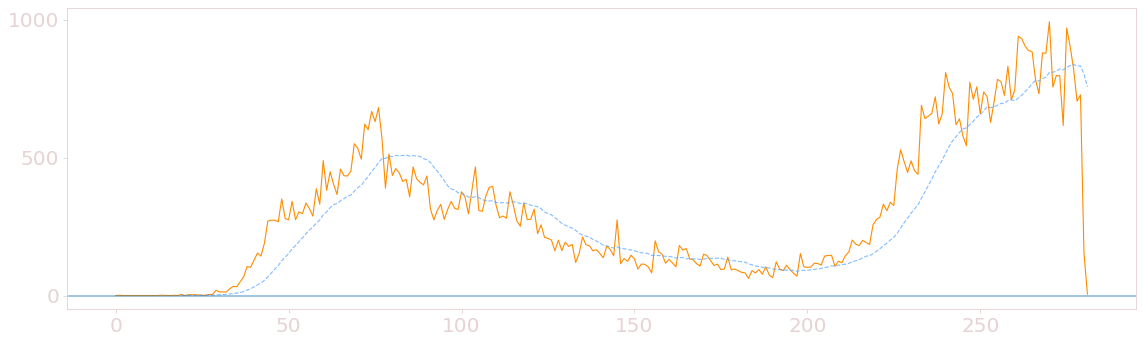

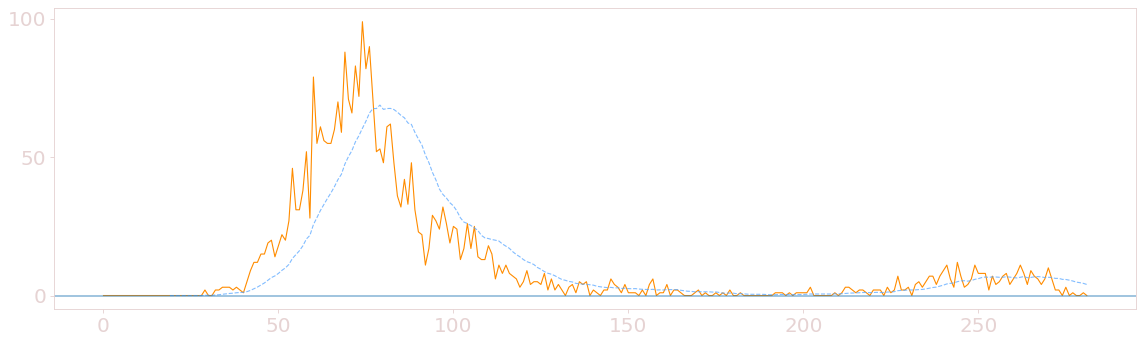

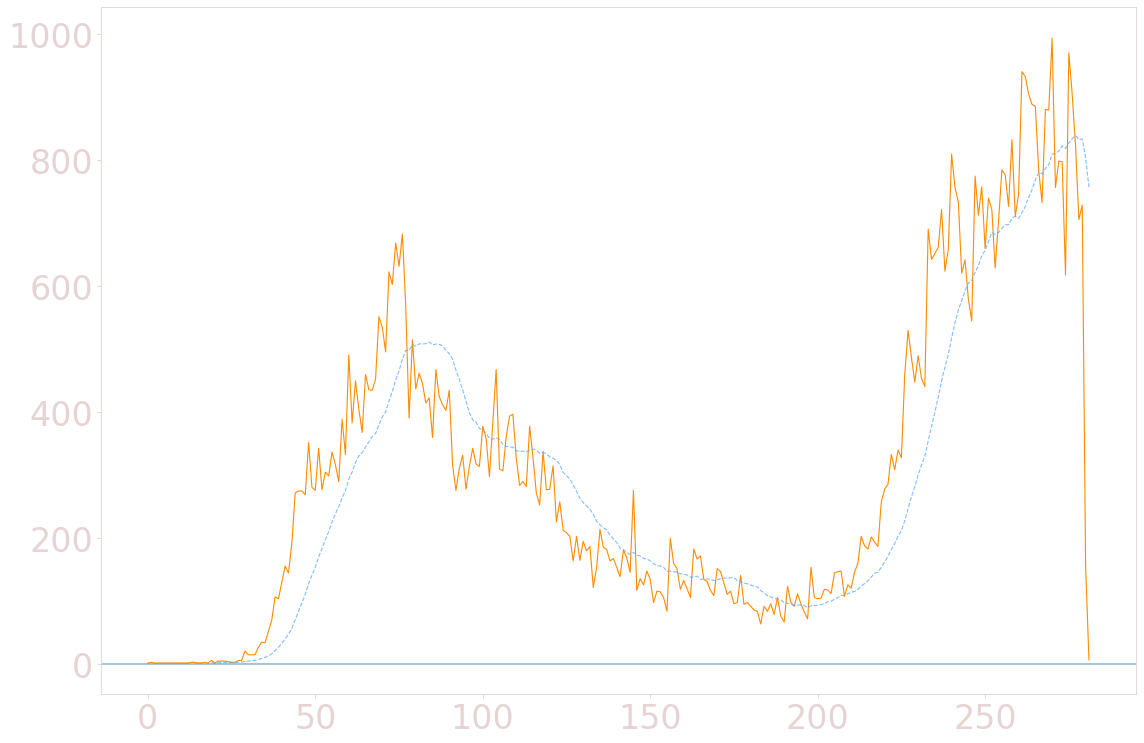

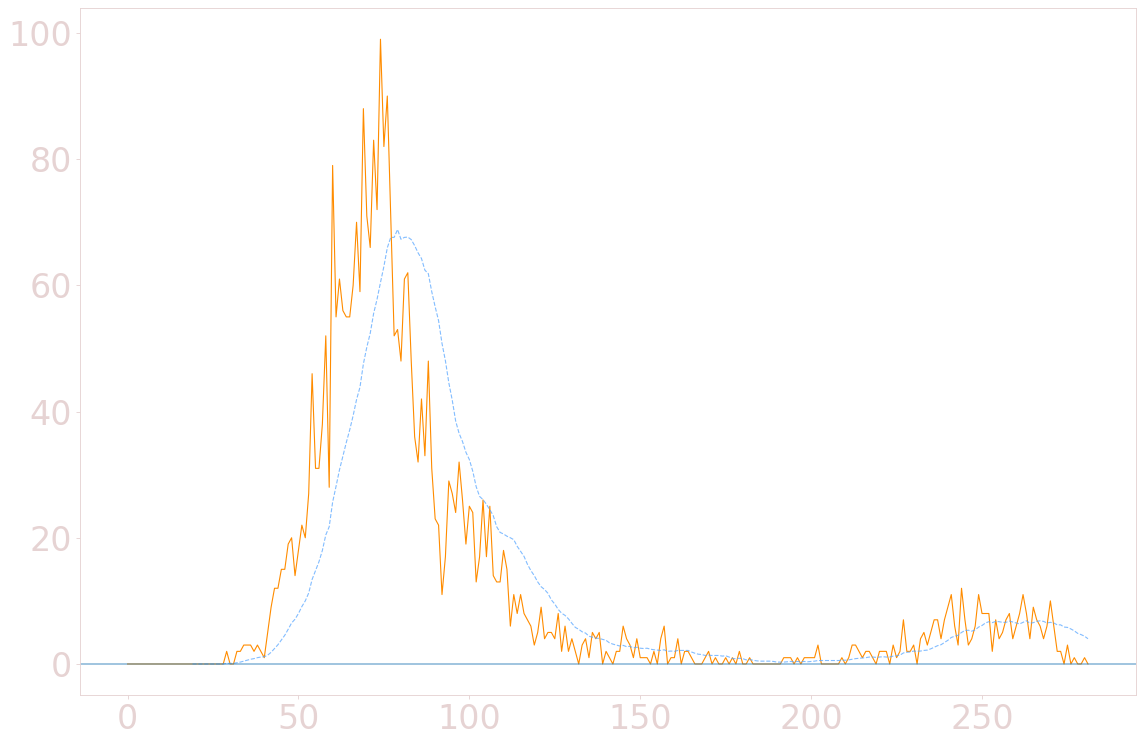

In [17]:
filename = f'static/images/graph/ontario-daily_cases_count.png'
chs.graph_frame(all_cases['days'],all_cases['count'],theme,filename,figsize = (15,5),font=18,save=1,rolling=20,legend=0,legend_title='',ticks=0,tr=0)

filename = f'static/images/graph/ontario-daily_deaths_count.png'
chs.graph_frame(all_deaths['days'],all_deaths['deaths'],theme,filename,figsize = (15,5),font=18,save=1,rolling=20,legend=0,legend_title='',ticks=0,tr=0)

filename = f'static/images/graph/ontario-daily_cases_count_s.png'
chs.graph_frame(all_cases['days'],all_cases['count'],theme,filename,figsize = (15,10),font=30,save=1,rolling=20,legend=0,legend_title='',ticks=0,tr=0)

filename = f'static/images/graph/ontario-daily_deaths_count_s.png'
chs.graph_frame(all_deaths['days'],all_deaths['deaths'],theme,filename,figsize = (15,10),font=30,save=1,rolling=20,legend=0,legend_title='',ticks=0,tr=0)
'''filename = f'static/images/graph/ontario-daily_cases-total_count.png'
chs.graph_frame_cumsum(all_cases['days'],all_cases['count'],theme,filename,figsize = (15,5),font=18,save=1,rolling=20,tr=0)

for age in ['<20','20s','30s','40s','50s','60s','70s','80s','90s']:
    all_data = all_age_count(age,on_db)
    filename = f'static/images/graph/{age}-total_count.png'
    chs.graph_frame(all_data['days'],all_data['count'],theme,filename,figsize = (15,5),font=22,save=1,rolling=20,legend=0,legend_title='',ticks=0)
    males = case_age_gender(age,'MALE',on_db)
    females = case_age_gender(age,'FEMALE',on_db)
    transgender = case_age_gender(age,'TRANSGENDER',on_db)
    for data,group in zip([males,females,transgender],['male','female','transgender']):
        filename = f'static/images/graph/{age}-total_count-{group}.png'
        chs.graph_frame(data['days'],data['count'],theme,filename,figsize = (10,3),font=22,save=1,rolling=20,legend=1,legend_title=group,ticks=0)'''

<Figure size 432x288 with 0 Axes>

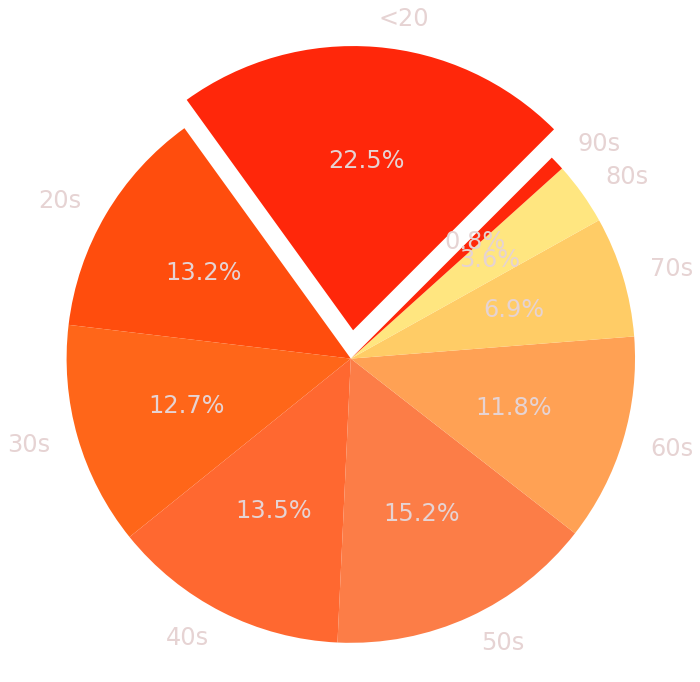

In [15]:
filename = f'static/images/pie/ontario-age_groups.png'
chs.graph_pie(on_age[:-1],'age_groups','count','title',filename,colour=theme,figsize=10,font=24,save=1,tr=0)

<Figure size 432x288 with 0 Axes>

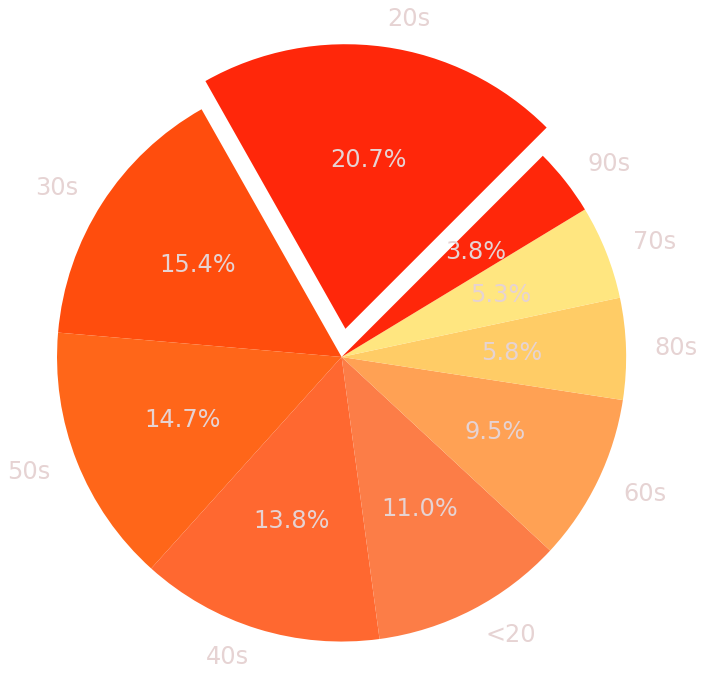

In [16]:
age_groups = get_pie(on_db,'Age_Group',total_cases,'')
filename = f'static/images/pie/all_ages-total_cases'
chs.graph_pie(age_groups,'age_group','count','title',filename,colour=theme,figsize=10,font=24,save=1,tr=0)

In [17]:
print('Past ',16,' days')

Past  16  days


In [18]:
utc_today

44144

<Figure size 432x288 with 0 Axes>

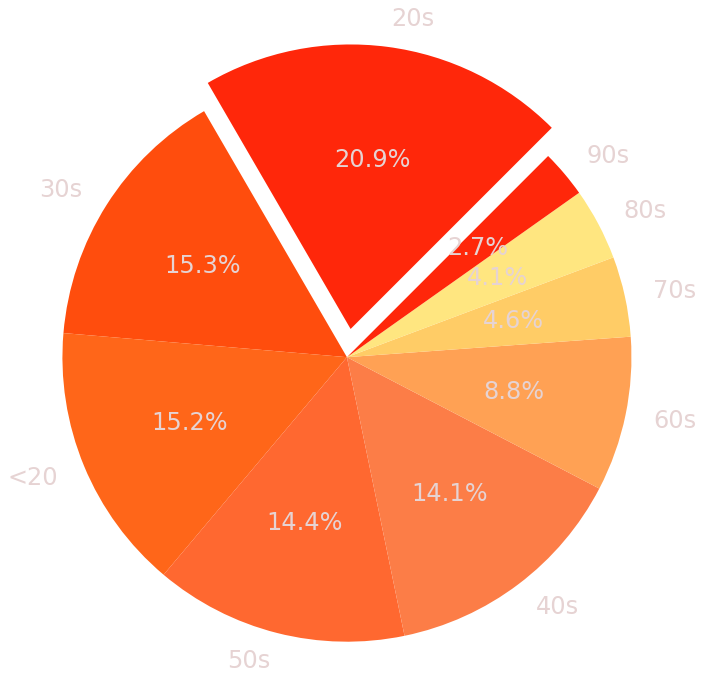

In [19]:
recent_cases = on_db[(on_db['utc'] >= utc_today - 16)]
recent_cases = recent_cases.sort_values(by='utc',ascending=False)
recent_groups = get_pie(recent_cases,'Age_Group',total_cases,'cases_by_age-16-days')
filename = f'static/images/pie/cases_by_age-16-days'
chs.graph_pie(recent_groups,'age_group','count','title',filename,colour=theme,figsize=10,font=24,save=1,tr=0)

In [20]:
def utc_count(dataframe):
    count_16 = dataframe['utc'].values
    unique_dates = dataframe['utc'].unique()
    # fatalalities in past 16 days
    fatal = dataframe[['utc','Outcome1']].copy()
    fatal['fatal'] = [ 1 if x == 'Fatal' else 0 for x in fatal['Outcome1']]
    outcome = fatal.groupby(['utc']).sum()
    outcome = outcome.reset_index()
    a = [[date_,int((count_16 == date_).sum())] for date_ in unique_dates]
    db = pd.DataFrame(a,columns=['date','count'])
    db['actual_date'] = db['date'].apply(lambda x: utc_to_date(x))
    db['days'] = db['actual_date'].apply(lambda x: str(x)[-2:])
    db = db.dropna()
    db['days'] = db['days'].astype(int)
    db['fatal'] = outcome['fatal']
    db = db.sort_values(by='days')
    return db

In [21]:
recent_count = recent_cases['utc'].values
unique_dates = recent_cases['utc'].unique()

In [22]:
a = [[date_,int((recent_count == date_).sum())] for date_ in unique_dates]
#recent_cases_count = pd.DataFrame(a,columns=['date','count'])
recent_cases_count = utc_count(recent_cases)

In [23]:
recent_cases_count = recent_cases_count.sort_values(by='date')#,ascending=False)
recent_cases_count = recent_cases_count.reset_index()
recent_cases_count

,index,date,count,actual_date,days,fatal
0,15,44128,952,2020-10-24,24,0
1,14,44129,891,2020-10-25,25,1
2,13,44130,785,2020-10-26,26,1
3,12,44131,863,2020-10-27,27,4
4,11,44132,908,2020-10-28,28,2
5,10,44133,911,2020-10-29,29,0
6,9,44134,1082,2020-10-30,30,8
7,8,44135,935,2020-10-31,31,3
8,7,44136,1103,2020-11-01,1,5
9,6,44137,964,2020-11-02,2,7


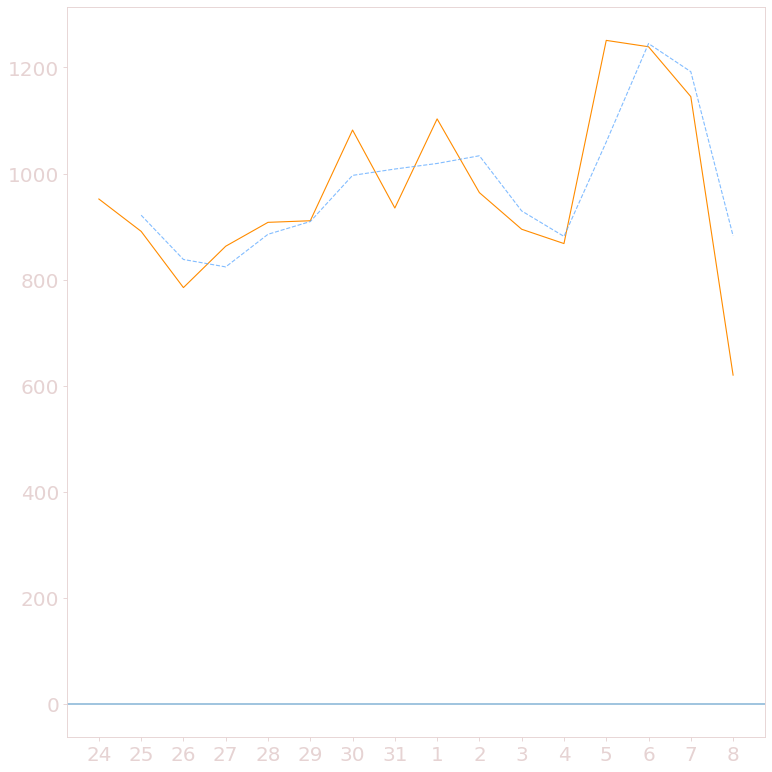

In [24]:
filename = f'static/images/graph/ontario-recent_daily_cases_count.png'
chs.graph_frame(recent_cases_count['days'],recent_cases_count['count'],theme,filename,figsize = (10,10),font=18,save=1,rolling=2,legend=0,legend_title='',ticks=1,tr=0)

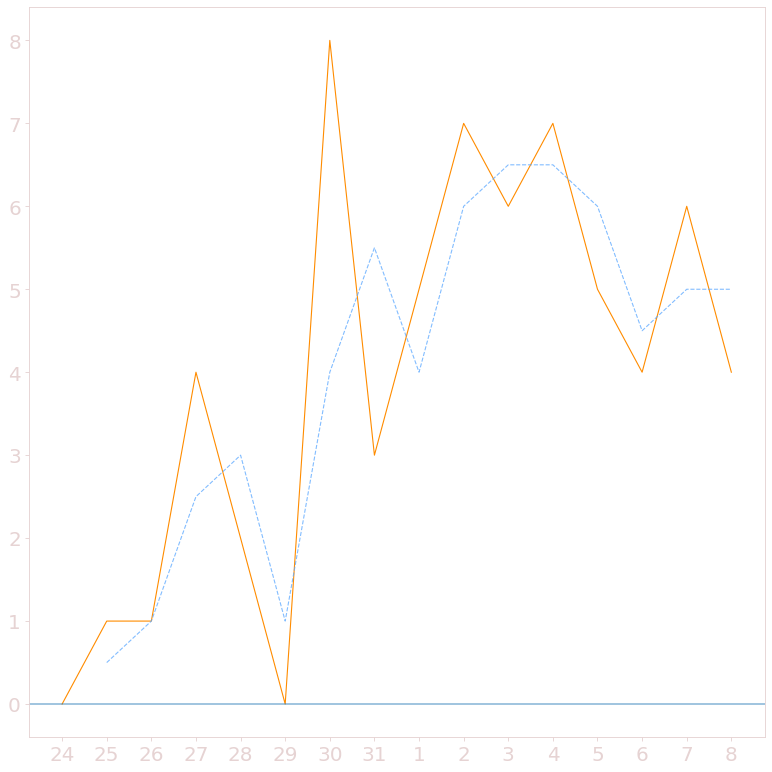

In [25]:
filename = f'static/images/graph/ontario-recent_daily_deaths_count.png'
chs.graph_frame(recent_cases_count['days'],recent_cases_count['fatal'],theme,filename,figsize = (10,10),font=18,save=1,rolling=2,legend=0,legend_title='',ticks=1,tr=0)

In [26]:
recent_cases_count['date'].unique()

array([44128, 44129, 44130, 44131, 44132, 44133, 44134, 44135, 44136,
       44137, 44138, 44139, 44140, 44141, 44142, 44143])

In [27]:
on_db[on_db['utc'] == 44077].groupby('Client_Gender')

In [28]:
female_16 = recent_cases[recent_cases['Client_Gender'] == 'FEMALE']
male_16 = recent_cases[recent_cases['Client_Gender'] == 'MALE']
transgender_16 = recent_cases[recent_cases['Client_Gender'] == 'TRANSGENDER']
female_16_count = utc_count(female_16)
male_16_count = utc_count(male_16)
transgender_16_count = utc_count(transgender_16)

a,b,c,d = [],[],[],[]
for date in recent_cases_count['date'].unique():
    actual = on_db[on_db['utc'] == date]['Case_Reported_Date'].values[0]
    try:
        m = male_16_count[male_16_count['date'] == date]['count'].values[0]
    except:
        m = 0
    try:
        f = female_16_count[female_16_count['date'] == date]['count'].values[0]
    except:
        f = 0
    try:
        t = transgender_16_count[transgender_16_count['date'] == date]['count'].values[0]
    except:
        t = 0
    a.append(m)
    b.append(f)
    c.append(t)
    d.append(actual)
recent_cases_count['m_count'] = a
recent_cases_count['f_count'] = b
recent_cases_count['t_count'] = c
recent_cases_count['actual_date'] = d
recent_cases_count = recent_cases_count.dropna()

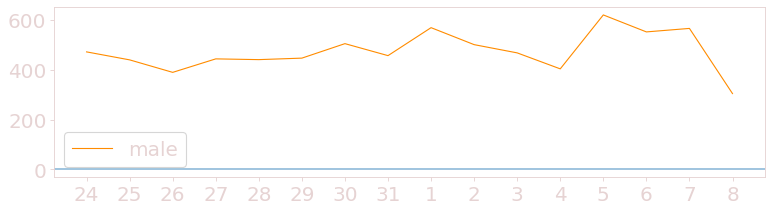

In [29]:
#plt.savefig(filename, facecolor=FACE,edgecolor=EDGE)
filename = f'static/images/graph/16-days-total_count-male.png'
chs.graph_frame(recent_cases_count['days'],recent_cases_count['m_count'],theme,filename,figsize = (10,3),font=18,save=1,rolling=0,legend=1,legend_title='male',ticks=1,tr=0)

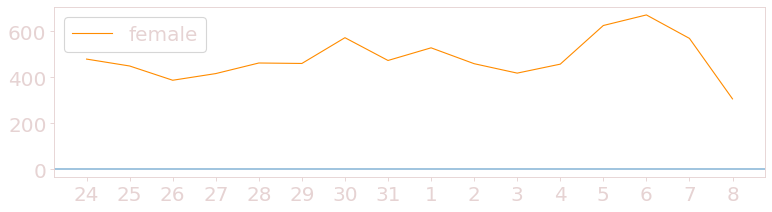

In [30]:
filename = f'static/images/graph/16-days-total_count-female.png'
chs.graph_frame(recent_cases_count['days'],recent_cases_count['f_count'],theme,filename,figsize = (10,3),font=18,save=1,rolling=0,legend=1,legend_title='female',ticks=1,tr=0)

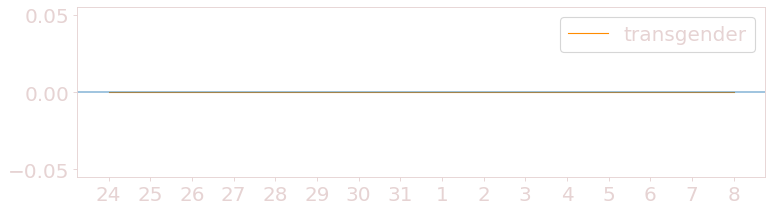

In [31]:
filename = f'static/images/graph/16-days-total_count-transgender.png'
chs.graph_frame(recent_cases_count['days'],recent_cases_count['t_count'],theme,filename,figsize = (10,3),font=18,save=1,rolling=0,legend=1,legend_title='transgender',ticks=1,tr=0)

<Figure size 432x288 with 0 Axes>

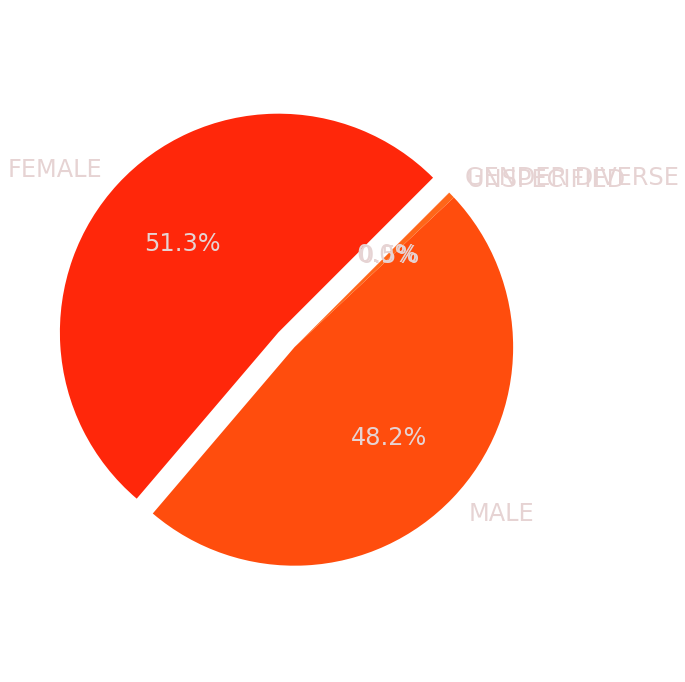

In [32]:
#plt.savefig(filename, facecolor=FACE,edgecolor=EDGE)
gender_groups = get_pie(on_db,'Client_Gender',total_cases,'gender-total_cases')
filename = f'static/images/pie/gender-total_cases'
chs.graph_pie(gender_groups,'client_gender','count','title',filename,colour=theme,figsize=10,font=24,save=1,tr=0)

In [33]:
gender_groups_sum = gender_groups['count'].sum()
gender_groups['pop%'] = round(gender_groups['count'] / gender_groups_sum,4)*100

<Figure size 432x288 with 0 Axes>

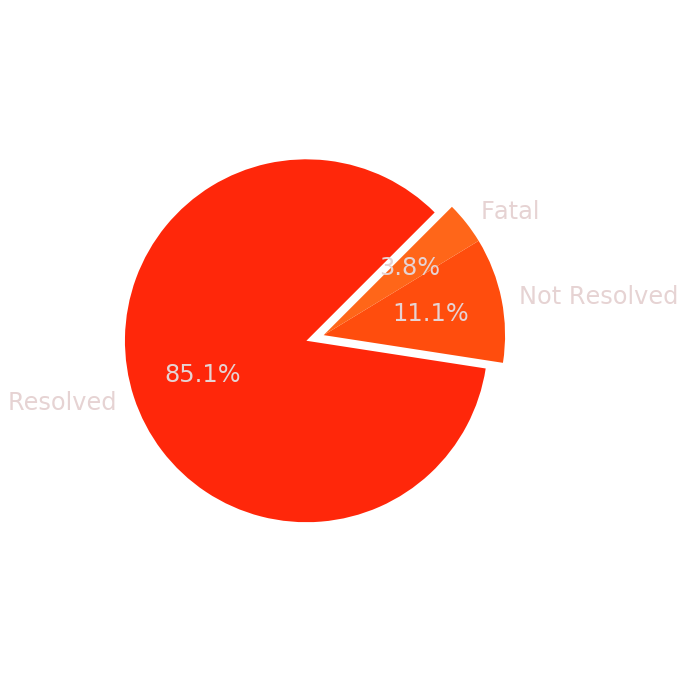

In [34]:
gender_groups.to_csv('datasets/2020/gender_infected.csv',index=False)

outcomes = get_pie(on_db,'Outcome1',total_cases,'outcome-total_cases')
filename = f'static/images/pie/outcome-total_cases'
chs.graph_pie(outcomes,'outcome','count','title',filename,colour=theme,figsize=10,font=24,save=1,tr=0)

In [35]:
outcomes.to_csv('datasets/2020/outcomes.csv',index=False)
print(outcomes)

        outcome  count  pop%
0      Resolved  72636  0.85
1  Not Resolved   9514  0.11
2         Fatal   3245  0.04


In [36]:
j = 0
a = [int(round(i*1000,2)/38) for i in outcomes['pop%']]
if sum(a) > 25:
    new_a = max(a) - 1
    t = a.index(max(a))
    a.remove(max(a))
    a.insert(t,new_a)

a = outcomes['pop%'].tolist()

o=["fa fa-user beige-text-blue","fa fa-user w3-text-black","fa fa-user beige-text-red"]
#o=['r','f','a']
lst=[]
k = 0
for i in a:
    b = i * 100
    for j in range(int(b)):
        lst.append(o[k])
    k = k + 1

lst2=[]
cnt = 0
for i in range(10):
    lsu=[]
    for j in range(10):
        v = lst[cnt]
        lsu.extend([v])
        cnt = cnt + 1
    lst2.append(lsu)

infected = pd.DataFrame(lst2,columns=['1','2','3','4','5','6','7','8','9','10'])
infected.to_csv('datasets/2020/infected.csv',index=False)

phu_cases = get_category_count(on_db,'Reporting_PHU_City',total_cases)
cases_date = get_category_count(on_db,'Accurate_Episode_Date',total_cases)
fatal = fatal.dropna()
print(fatal)

  age_group  fatal-f  fatal-m  fatal-t  fatal-u  fatal-total  fatal%
6       80s    631.0    537.0      0.0      0.0       1168.0    0.36
8       90s    714.0    329.0      0.0      0.0       1043.0    0.32
7       70s    223.0    343.0      0.0      0.0        566.0    0.18
5       60s    107.0    188.0      0.0      0.0        295.0    0.09
2       50s     41.0     65.0      0.0      0.0        106.0    0.03
3       40s      9.0     18.0      0.0      0.0         27.0    0.01
1       30s      0.0      7.0      0.0      0.0          7.0    0.00
0       20s      1.0      3.0      0.0      0.0          4.0    0.00
4       <20      1.0      0.0      0.0      0.0          1.0    0.00
9   UNKNOWN      0.0      0.0      0.0      0.0          0.0    0.00


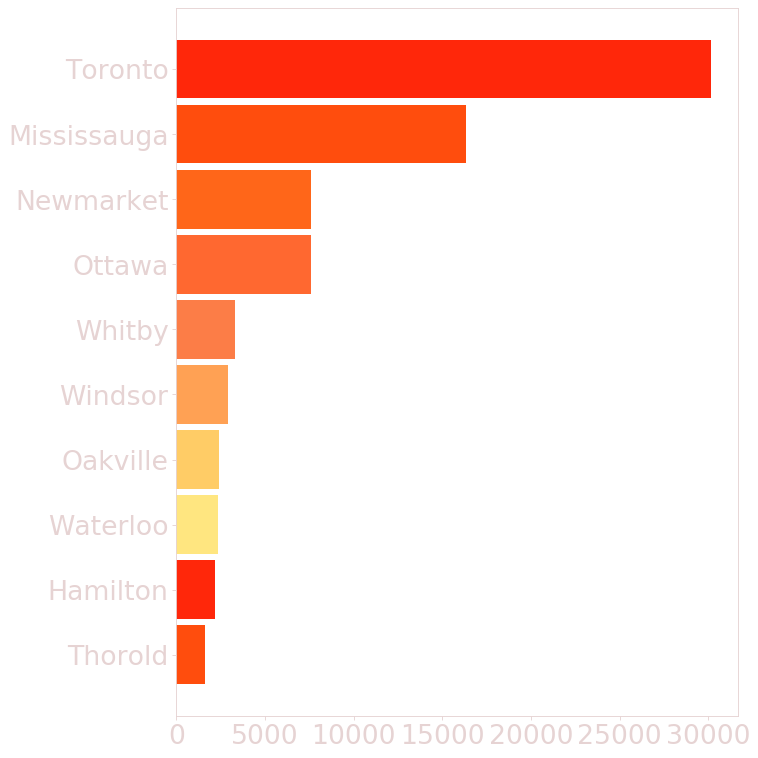

In [37]:
top_10_phu = phu_cases.head(10)
filename = f'static/images/bar/ontario-reporting_phu_city-top10.png'
chs.graph_bar(top_10_phu,'reporting_phu_city','count','title',theme,filename,figsize = (10,10),font=18,save=1,rolling=2,tr=0)

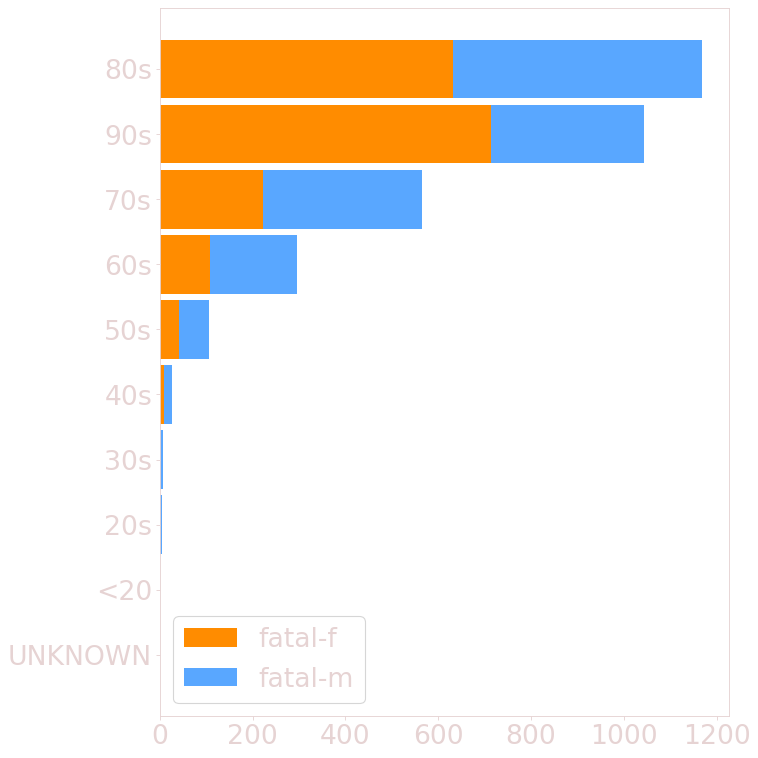

In [38]:
filename = 'static/images/bar/fatalities.png'
chs.graph_bar_stacked(fatal,'age_group','fatal-f','fatal-m','title',theme,filename,figsize = (10,10),font=18,save=1,rolling=2,tr=0)

In [39]:
recent_cases_count = recent_cases_count.dropna()

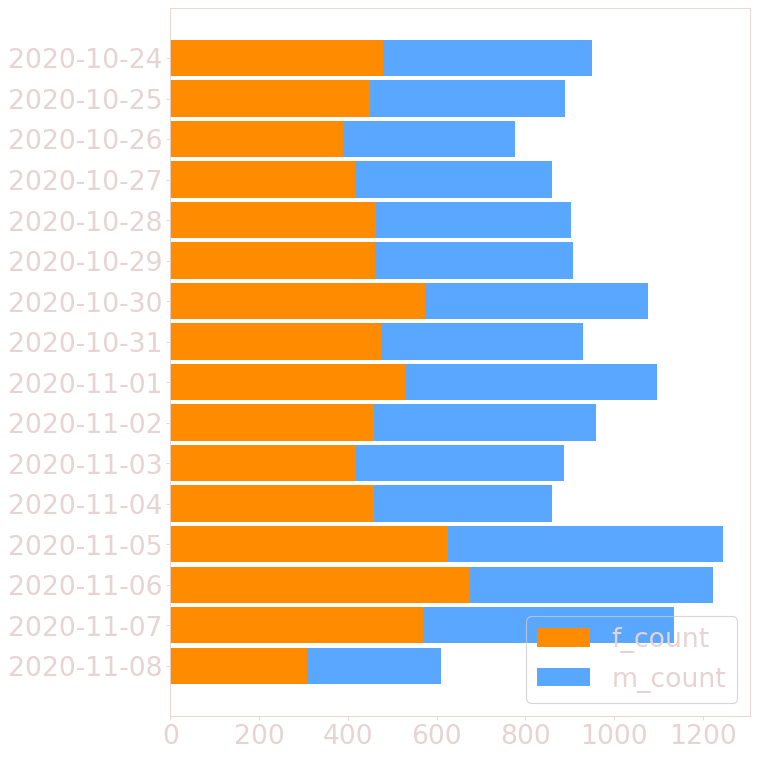

In [40]:
filename = 'static/images/bar/last16day-cases.png'
chs.graph_bar_stacked(recent_cases_count,'actual_date','f_count','m_count','title',theme,filename,figsize = (10,10),font=18,save=1,rolling=2,tr=0)

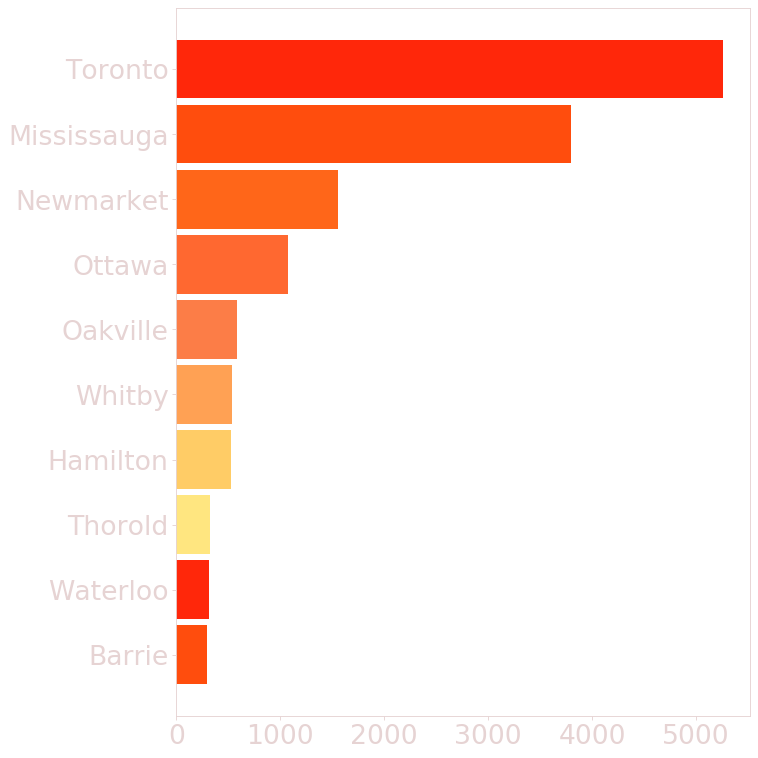

In [41]:
recent_top_10_phu = get_category_count(recent_cases,'Reporting_PHU_City',total_cases)
recent_top_10_phu = recent_top_10_phu.head(10)
filename = 'static/images/bar/ontario-reporting_phu_city-top10-recent.png'
chs.graph_bar(recent_top_10_phu,'reporting_phu_city','count','title',theme,filename,figsize = (10,10),font=18,save=1,rolling=2,tr=0)

In [42]:
end = time.time()
job_time = round((end - start),3)

print(job_time)

13.404
